# **Bank Churn - ML Model**
Author: André Paiva (Xornotor)

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, tree
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')
mpl.rcParams['figure.dpi'] = 100

In [2]:
df_train = pd.read_csv('./data/train.csv', index_col='id')
with pd.option_context('mode.chained_assignment', None):
    df_train['Geography'] = df_train['Geography'].astype('category')
    df_train['Gender'] = df_train['Gender'].astype('category')
    df_train['Age'] = df_train['Age'].astype('int')
    df_train['HasCrCard'] = df_train['HasCrCard'].astype('bool')
    df_train['IsActiveMember'] = df_train['IsActiveMember'].astype('bool')
    df_train['Exited'] = df_train['Exited'].astype('bool')


In [3]:
df_train_filtered = df_train[['CreditScore', 'Geography', 'Gender',
                              'Age', 'Tenure', 'Balance',
                              'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                              'EstimatedSalary', 'Exited']]
df_train_filtered = pd.get_dummies(df_train_filtered)

train_X_sel = df_train_filtered[['Age', 'Balance', 'NumOfProducts', 'IsActiveMember',
                                 'Geography_Spain', 'Geography_France', 'Geography_Germany',
                                 'Gender_Male', 'Gender_Female',]].to_numpy()

train_X = df_train_filtered[['CreditScore', 'Geography_Spain', 'Geography_France',
                                'Geography_Germany','Gender_Male', 'Gender_Female',
                                'Age', 'Tenure', 'Balance', 'NumOfProducts',
                                'HasCrCard', 'IsActiveMember', 'EstimatedSalary']].to_numpy()

train_Y = df_train_filtered['Exited'].to_numpy()

In [4]:
df_test = pd.read_csv('./data/test.csv', index_col='id')
with pd.option_context('mode.chained_assignment', None):
    df_test['Geography'] = df_test['Geography'].astype('category')
    df_test['Gender'] = df_test['Gender'].astype('category')
    df_test['Age'] = df_test['Age'].astype('int')
    df_test['HasCrCard'] = df_test['HasCrCard'].astype('bool')
    df_test['IsActiveMember'] = df_test['IsActiveMember'].astype('bool')

In [5]:
df_test_filtered = df_test[['CreditScore', 'Geography', 'Gender',
                              'Age', 'Tenure', 'Balance',
                              'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                              'EstimatedSalary']]
df_test_filtered = pd.get_dummies(df_test_filtered)

test_X_sel = df_test_filtered[['Age', 'Balance', 'NumOfProducts', 'IsActiveMember',
                               'Geography_Spain', 'Geography_France', 'Geography_Germany',
                               'Gender_Male', 'Gender_Female',]].to_numpy()

test_X = df_test_filtered[['CreditScore', 'Geography_Spain', 'Geography_France',
                                'Geography_Germany','Gender_Male', 'Gender_Female',
                                'Age', 'Tenure', 'Balance', 'NumOfProducts',
                                'HasCrCard', 'IsActiveMember', 'EstimatedSalary']].to_numpy()

In [6]:
'''
predictor = MLPClassifier((3, 1),
                            solver='sgd',
                            activation='logistic',
                            learning_rate='constant',
                            learning_rate_init=10e-25,
                            max_iter=20,
                            alpha=0,
                            n_iter_no_change=10)
'''

predictor1 = tree.DecisionTreeClassifier()
predictor2 = HistGradientBoostingClassifier(max_iter=1000, l2_regularization=1e-1)
predictor3 = RandomForestClassifier(n_estimators=120, random_state=1)
predictor4 = KNeighborsClassifier(n_neighbors=5)
predictor = VotingClassifier(estimators=[('DecisionTree', predictor1),
                                    ('HistGradientBoost', predictor2),
                                    ('RandomForest', predictor3)],
                                    voting='soft',
                                    weights=[2, 4, 3])

#predictor1.fit(train_X, train_Y)
#predictor2.fit(train_X, train_Y)
#predictor3.fit(train_X, train_Y)
#predictor4.fit(train_X, train_Y)
predictor.fit(train_X_sel, train_Y)

VotingClassifier(estimators=[('DecisionTree', DecisionTreeClassifier()),
                             ('HistGradientBoost',
                              HistGradientBoostingClassifier(l2_regularization=0.1,
                                                             max_iter=1000)),
                             ('RandomForest',
                              RandomForestClassifier(n_estimators=120,
                                                     random_state=1))],
                 voting='soft', weights=[2, 4, 3])

In [7]:
print(metrics.accuracy_score(train_Y, predictor.predict(train_X_sel)))

test_Y = predictor.predict(test_X_sel)
df_test['Exited'] = test_Y
survivor_predictions = df_test['Exited'].astype('float')
survivor_predictions.to_csv("predictions.csv")
df_test.groupby('Exited')['Balance'].count()

0.9298144624743993


Exited
False    91220
True     18803
Name: Balance, dtype: int64

In [8]:
test_Y = predictor.predict_proba(test_X_sel)
df_test['Exited'] = test_Y[:, 1]
survivor_predictions = df_test['Exited'].astype('float')
survivor_predictions.to_csv("predictions.csv")

<Axes: ylabel='Count'>

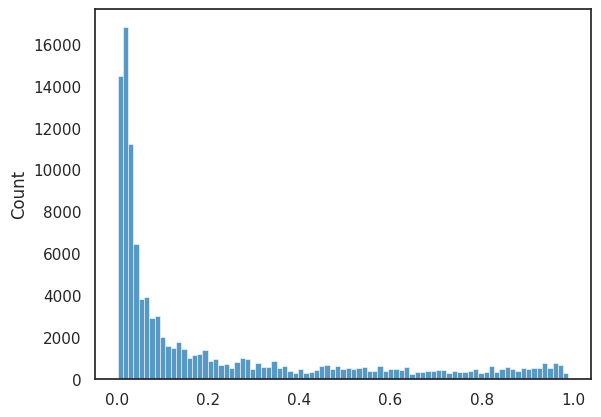

In [9]:
sns.histplot(test_Y[:, 1])

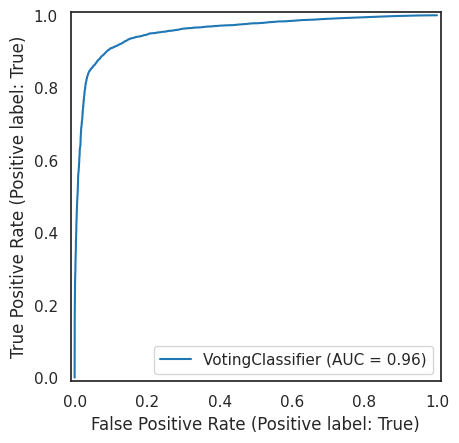

In [10]:
rfc_disp = metrics.RocCurveDisplay.from_estimator(predictor,
                                                  train_X_sel, train_Y)